In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import h5py
import matplotlib.pyplot as plt
device = torch.device('cpu')

In [ ]:
## Take in the dataset and normalize / rearrange
class binary_data_norm(Dataset):
    def __init__(self, images, labels):
        self.images = torch.tensor(images / 255.0, dtype=torch.float32)  # Normalize
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].permute(2, 0, 1)  # Rearrange dimensions
        label = self.labels[idx]
        return image, label

In [11]:
## Simple feed forward linear neural network with two layers
class SimpleLinearNN(nn.Module):
    def __init__(self, input_size=64*64*3, hidden_size=128, output_size=2):
        super(SimpleLinearNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p = 0.1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [12]:
# Load HDF5 data
def load_h5_data(train_path, test_path):
    with h5py.File(train_path, 'r') as train_file:
        train_images = train_file['train_set_x'][()]
        train_labels = train_file['train_set_y'][()]
    with h5py.File(test_path, 'r') as test_file:
        test_images = test_file['test_set_x'][()]
        test_labels = test_file['test_set_y'][()]

    return train_images, train_labels, test_images, test_labels

In [13]:
## Training loop, run for number of epochs and train NN
def train(model, train_loader, loss_func, optim, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        loss_sum = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optim.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optim.step()

            loss_sum += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss_sum/len(train_loader):.4f}")

## Evaluation function: 
def evaluate_images(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    incorrect_indices = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            incorrect_indices.extend((predicted != labels).nonzero(as_tuple=True)[0].tolist())

    print(f"Accuracy: {100 * correct / total:.2f}%")
    return incorrect_indices

In [ ]:
# Load in data
train_path = 'train_catvnoncat.h5'
test_path = 'test_catvnoncat.h5'
train_images, train_labels, test_images, test_labels = load_h5_data(train_path, test_path)

# Prep datasets
train_dataset = binary_data_norm(train_images, train_labels)
test_dataset = binary_data_norm(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Initialization
model = SimpleLinearNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train model
train(model, train_loader, loss_func, optimizer, num_epochs=1000)

# Evaluate the output
incorrect_indices = evaluate_images(model, test_loader)
# Print incorrect indices
print("Incorrect Indices:", incorrect_indices)

Epoch [1/1000], Loss: 1.0506
Epoch [2/1000], Loss: 0.6415
Epoch [3/1000], Loss: 0.5913
Epoch [4/1000], Loss: 0.6795
Epoch [5/1000], Loss: 0.6638
Epoch [6/1000], Loss: 0.6376
Epoch [7/1000], Loss: 0.5518
Epoch [8/1000], Loss: 0.5249
Epoch [9/1000], Loss: 0.5050
Epoch [10/1000], Loss: 0.4941
Epoch [11/1000], Loss: 0.4717
Epoch [12/1000], Loss: 0.4594
Epoch [13/1000], Loss: 0.5105
Epoch [14/1000], Loss: 0.4381
Epoch [15/1000], Loss: 0.3933
Epoch [16/1000], Loss: 0.4080
Epoch [17/1000], Loss: 0.3793
Epoch [18/1000], Loss: 0.3415
Epoch [19/1000], Loss: 0.3542
Epoch [20/1000], Loss: 0.3615
Epoch [21/1000], Loss: 0.3539
Epoch [22/1000], Loss: 0.3062
Epoch [23/1000], Loss: 0.2741
Epoch [24/1000], Loss: 0.2836
Epoch [25/1000], Loss: 0.2993
Epoch [26/1000], Loss: 0.4104
Epoch [27/1000], Loss: 0.3651
Epoch [28/1000], Loss: 0.2731
Epoch [29/1000], Loss: 0.2992
Epoch [30/1000], Loss: 0.3579
Epoch [31/1000], Loss: 0.4168
Epoch [32/1000], Loss: 0.2724
Epoch [33/1000], Loss: 0.2525
Epoch [34/1000], Lo

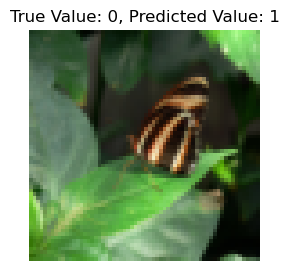

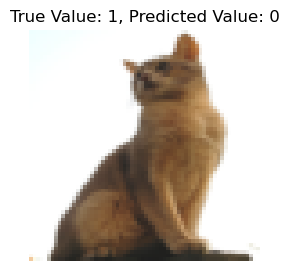

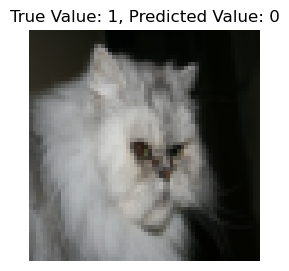

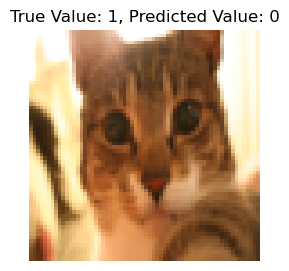

In [16]:
## Plotting loop (plots first 4 images)
for i, idx in enumerate(incorrect_indices[:4]):
    image, true_label = test_dataset[idx]
    image = image.to(device).contiguous().reshape(1, 3, 64, 64) # reshape to run model on 

    # run model on image
    with torch.no_grad():
        output = model(image)
        _, predicted_label = torch.max(output, 1)
    
    # reshape image
    image = image.contiguous().reshape(3, 64, 64).cpu().numpy().transpose(1, 2, 0)  # Reshape back to (H, W, C)
    
    # Plot and show
    plt.figure(figsize=(3, 3))
    plt.imshow(image)
    plt.title(f"True Value: {true_label}, Predicted Value: {predicted_label.item()}")
    plt.axis('off')
    plt.show()